# Setup

In [1]:
##########################################################
# Relative Imports
##########################################################
import functools
import sys
from functools import partial
from os.path import isfile
from os.path import join
from typing import List

import torch


def find_pkg(name: str, depth: int):
    if depth <= 0:
        ret = None
    else:
        d = [".."] * depth
        path_parts = d + [name, "__init__.py"]

        if isfile(join(*path_parts)):
            ret = d
        else:
            ret = find_pkg(name, depth - 1)
    return ret


def find_and_ins_syspath(name: str, depth: int):
    path_parts = find_pkg(name, depth)
    if path_parts is None:
        raise RuntimeError("Could not find {}. Try increasing depth.".format(name))
    path = join(*path_parts)
    if path not in sys.path:
        sys.path.insert(0, path)


try:
    import caldera
except ImportError:
    find_and_ins_syspath("caldera", 3)


# Data generation

In [2]:
from caldera.transforms import networkx as nxt
from caldera.transforms import Compose
from caldera.utils import functional as fn
import numpy as np


preprocess = Compose(
    [
        nxt.NetworkxSetDefaultFeature(
            node_default={"source": False, "target": False, "shortest_path": False},
            edge_default={"shortest_path": False},
        ),
        nxt.NetworkxAttachNumpyBool("node", "source", "_features"),  # label nodes as 'start'
        nxt.NetworkxAttachNumpyBool("node", "target", "_features"),  # label nodes as 'end'
        
        # attached weight
        nxt.NetworkxAttachNumpyFeatures(
            "edge", "weight", "_features", encoding=fn.map_each(lambda x: np.array([x]))
        ),
        nxt.NetworkxAttachNumpyOneHot(
            "edge", "shortest_path", "_target", classes=[True, False]
        ),  # label edge as shortest_path
        nxt.NetworkxSetDefaultFeature(
            global_default={
                "_features": np.array([1.0]),
                "_target": np.array([1.0]),
            },
            node_default={
                '_target': np.array([1.0])
            }
        ),
        nxt.NetworkxNodesToStr(),
        nxt.NetworkxToDirected(),
    ]
)


In [3]:
from torch import distributions as dist

class DistCaster(object):
    
    def __init__(self, dist: dist.Distribution):
        self.dist = dist
        
    def sample(self):
        return self.dist.sample().item()
    
class AsInt(DistCaster):
    
    def __int__(self):
        return int(self.sample())
    
class AsFloat(DistCaster):
    
    def __float__(self):
        return float(self.sample())

In [4]:
from caldera.utils.nx.generators import random_graph
import networkx as nx
import random

n_nodes = AsInt(dist.Uniform(50, 100))
density = AsFloat(dist.Uniform(0.001, 0.05))
weight = AsFloat(dist.Uniform(0.1, 20.))

random_graph(n_nodes, density=density, weight=weight, weight_key = 'weight')

def get_shortest_paths(g: nx.Graph):
    source = random.choice(list(g.nodes()))
    target = random.choice(list(g.nodes()))
    try:
        paths = list(nx.all_shortest_paths(g, weight='weight', source=source, target=target))
    except nx.NetworkXNoPath:
        paths = []
    return source, target, paths

def mark_shortest_path(g: nx.Graph):
    for _, ndata in g.nodes(data=True):
        ndata['source'] = False
        ndata['target'] = False
    for _, _, edata in g.edges(data=True):
        edata['shortest_path'] = False
        
    source, target, paths = get_shortest_paths(g)
    g.nodes[source]['source'] = True
    g.nodes[target]['target'] = True
    for path in paths:
        for n1, n2 in nx.utils.pairwise(path):
            g.edges[(n1, n2)]['shortest_path'] = True
    return g
    
    
g = random_graph(n_nodes, density=density, weight=weight, weight_key = 'weight')
mark_shortest_path(g)
list(preprocess(g).edges(data=True))[:3]

[('0',
  '22',
  {'weight': 11.952595710754395,
   'shortest_path': False,
   '_features': array([11.95259571]),
   '_target': array([0., 1.])}),
 ('0',
  '24',
  {'weight': 2.9898087978363037,
   'shortest_path': False,
   '_features': array([2.9898088]),
   '_target': array([0., 1.])}),
 ('0',
  '38',
  {'weight': 17.992311477661133,
   'shortest_path': False,
   '_features': array([17.99231148]),
   '_target': array([0., 1.])})]

In [5]:
from caldera.data import GraphData
from tqdm.auto import tqdm
from multiprocessing import Pool


def random_train_graph():
    n_nodes = AsInt(dist.Uniform(50, 100))
    density = AsFloat(dist.Uniform(0.001, 0.05))
    weight = AsFloat(dist.Uniform(0.1, 20))
    g = random_graph(n_nodes, density=density, weight=weight, weight_key = 'weight')
    return mark_shortest_path(g)

def random_eval_graph():
    n_nodes = AsInt(dist.Uniform(50, 100))
    density = AsFloat(dist.Uniform(0.001, 0.05))
    weight = AsFloat(dist.Uniform(0.1, 20))
    g = random_graph(n_nodes, density=density, weight=weight, weight_key = 'weight')
    return mark_shortest_path(g)

def graphs_to_datalist(graphs):
    input_datalist = [GraphData.from_networkx(g, feature_key='_features') for g in tqdm(graphs)]
    target_datalist = [GraphData.from_networkx(g, feature_key='_target') for g in tqdm(graphs)]
    return input_datalist, target_datalist

def _gen_train_data(*args):
    return random_train_graph()

def _get_eval_data(*args):
    return random_eval_graph()

def generate_data(n, f):
    pbar = tqdm(total=n)
    with Pool(2) as pool:
        results = pool.imap_unordered(f, range(n), chunksize=100)
        graphs = []
        while True:
            try:
                graphs += next(results)
                pbar.update()
            except StopIteration:
                pass
        return graphs
    
    
n_train_graphs = 5000
n_eval_graphs = 500

# train_graphs = generate_data(n_train_graphs, _gen_train_data)

train_graphs = [random_train_graph() for _ in tqdm(range(n_train_graphs))]
eval_graphs = [random_eval_graph() for _ in tqdm(range(n_eval_graphs))]

processed_train_graphs = preprocess(train_graphs)
processed_eval_graphs = preprocess(eval_graphs)

train_input, train_target = graphs_to_datalist(processed_train_graphs)
eval_input, eval_target = graphs_to_datalist(processed_eval_graphs)

# Network

In [10]:
from caldera.data import GraphTuple
from caldera.data import GraphBatch
from torch import nn
from caldera import gnn

def gt_to_data(gt: GraphTuple, b: GraphBatch) -> GraphBatch:
    return GraphBatch(
        node_attr=gt.x,
        edge_attr=gt.e,
        global_attr=gt.g,
        edges=b.edges,
        node_idx=b.node_idx,
        edge_idx=b.edge_idx
    )


def as_data(f):
    @functools.wraps(f)
    def wrapped(data, *args, **kwargs):
        return gt_to_data(f(data, *args, **kwargs), data)

    return wrapped


def cat(batch1: GraphBatch, batch2: GraphBatch) -> GraphBatch:
    return GraphBatch(
        node_attr=torch.cat([batch1.x, batch2.x], dim=1),
        edge_attr=torch.cat([batch1.e, batch2.e], dim=1),
        global_attr=torch.cat([batch1.g, batch2.g], dim=1),
        edges=batch1.edges,
        node_idx=batch1.node_idx,
        edge_idx=batch1.edge_idx,
    )


class Network(nn.Module):
    def __init__(self):
        super().__init__()
        dense = partial(
            gnn.Flex(gnn.Dense), ..., layer_norm=True, dropout=0., activation=nn.ReLU
        )
        linear = partial(gnn.Flex(nn.Linear), ...)

        self.encode = gnn.GraphEncoder(
            edge_block=gnn.EdgeBlock(dense(8)),
            node_block=gnn.NodeBlock(dense(8)),
            global_block=gnn.GlobalBlock(dense(8)),
        )
        self.core = gnn.GraphCore(
            edge_block=gnn.AggregatingEdgeBlock(
                dense(*[8]*5)
            ),
            node_block=gnn.AggregatingNodeBlock(
                dense(*[8]*5), 
                edge_aggregator=gnn.Flex(gnn.Aggregator)("add")
            ),
            global_block=gnn.AggregatingGlobalBlock(
                dense(*[8]*5),
                edge_aggregator=gnn.Flex(gnn.Aggregator)("add"),
                node_aggregator=gnn.Flex(gnn.Aggregator)("add"),
            ),
            pass_global_to_edge=True,
            pass_global_to_node=True
        )
        self.decode = gnn.GraphEncoder(
            edge_block=gnn.EdgeBlock(dense(8)),
            node_block=gnn.NodeBlock(dense(8)),
            global_block=gnn.GlobalBlock(dense(8)),
        )
        self.out = gnn.GraphEncoder(
            edge_block=gnn.EdgeBlock(
                nn.Sequential(
                    linear(2), 
#                     nn.Softmax(1)
                ),
            ),
            node_block=gnn.NodeBlock(
                nn.Sequential(
                    linear(1), 
#                     nn.Softmax(1)
                ),
            ),
            global_block=gnn.GlobalBlock(
                nn.Sequential(
                    linear(1), 
#                     nn.Softmax(1)
                ),
            )
        )

    def forward(
        self, data: GraphBatch, steps: int, save_all: bool = True
    ) -> List[GraphBatch]:
        latent0 = as_data(self.encode)(data)
        data = latent0
        
        outputs = []
        for _ in range(steps):
            # core
            data = as_data(self.core)(data)
            
            # decode
            data = as_data(self.decode)(data)
            
            # out
            out = as_data(self.out)(data)
            if save_all:
                outputs.append(out)
            else:
                outputs = [out]
        return outputs

from caldera.data import GraphDataLoader

train_loader = GraphDataLoader(train_input, train_target, batch_size=512, pin_memory=True, shuffle=True)
eval_loader = GraphDataLoader(eval_input, eval_target, batch_size=len(eval_input), pin_memory=True, shuffle=False)  


def prime_model(model, loader):
    for x, y in loader:
        y_hat = model.forward(x, 3)[-1]
        assert y_hat.shape == y.shape
        
net = Network()

prime_model(net, train_loader)

for x, y in train_loader:
    break
    
print(x)
print(y)
print(net(x, 2)[-1])

<GraphBatch size(n,e,g)=torch.Size([38359, 75774, 512]) features(n,e,g)=torch.Size([2, 1, 1])>
<GraphBatch size(n,e,g)=torch.Size([38359, 75774, 512]) features(n,e,g)=torch.Size([1, 2, 1])>
<GraphBatch size(n,e,g)=torch.Size([38359, 75774, 512]) features(n,e,g)=torch.Size([1, 2, 1])>


In [12]:
foo = partial(gnn.Flex(nn.Linear))
lin1 = foo(5, 5)
lin2 = foo(5, 55)
print(lin1)
print(lin2)

FlexBlock(
	(unresolved_module): Linear(5, 5, 
)
FlexBlock(
	(unresolved_module): Linear(5, 55, 
)


# Training

In [13]:
from IPython import display
from matplotlib import pyplot as plt
%matplotlib inline

device = 'cuda:0'
net = Network()
prime_model(net, train_loader)
net.to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.001)
loss_fn = torch.nn.BCELoss()

logged = {}

def log_value(name, value):
    logged.setdefault(name, [])
    logged[name].append(value)

def extract(name, x, y):
    x_arr, y_arr = [], []
    for values in logged[name]:
        x_arr.append(values[x])
        y_arr.append(values[y])
    return x_arr, y_arr

import seaborn as sns

def edge_plot(net, x, y, steps, device, ax=None):
    x = x.to(device)
    y = y.to(device)
    y_hats = net(x, steps)
    sns.heatmap(torch.cat([y.e[:, :1] for y in y_hats] + [y.e[:, :1]], 1).detach().cpu().numpy(), ax=ax)
    
    
for epoch in tqdm(range(50)):
    
    running_loss = torch.tensor(0., device=device)
    for x, y in tqdm(train_loader):
        x = x.to(device)
        y = y.to(device)
        net.train()
        y_hat_list = net(x, 10, save_all=True)
        
        out_losses = []
        for y_hat in y_hat_list:
            x_loss = loss_fn(y_hat.x, y.x)
            e_loss = loss_fn(y_hat.e, y.e)
            g_loss = loss_fn(y_hat.g, y.g)
            out_loss = x_loss + e_loss + g_loss
            out_losses.append(out_loss)
        loss = torch.cat([l.unsqueeze(0) for l in out_losses]).sum() / len(y_hat_list)
        
        running_loss += loss
        
        # back prop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    log_value('train_loss', {'epoch': epoch, 'value': running_loss.detach().cpu().item()})
    
    net.eval()
    figs = []
    if epoch % 1 == 0:
        fig, axes = plt.subplots()
        figs.append(fig)
        ax = axes
        ax.ticklabel_format(useOffset=False) 
        ax.plot(*extract('train_loss', 'epoch', 'value'))
        
    if epoch % 1 == 0:
        x, y = eval_loader.first()
        fig, axes = plt.subplots()
        figs.append(fig)
        ax = axes
        edge_plot(net, x, y, 10, device, ax)
        
    if figs:
        display.clear_output(wait=True)
        for fig in figs:
            display.display(fig)

RuntimeError: CUDA error: device-side assert triggered

In [ ]:

import seaborn as sns

def edge_plot(net, x, y, steps, device, ax=None):
    x = x.to(device)
    y = y.to(device)
    y_hats = net(x, steps)
    sns.heatmap(torch.cat([y.e[:, :1] for y in y_hats] + [y.e[:, :1]], 1).detach().cpu().numpy(), ax=ax)
    
x, y = eval_loader.first()
edge_plot(net, x, y, 10, device)
# sns.heatmap(torch.nn.Softmax(1)(y_hats[0].e).detach().cpu().numpy())

<AxesSubplot:>

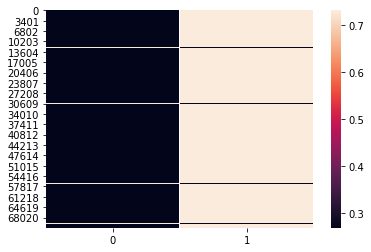

In [57]:
sns.heatmap(torch.nn.Softmax(1)(y.e).detach().cpu().numpy())

/home/justin/anaconda3/envs/caldera/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


<AxesSubplot:ylabel='Density'>

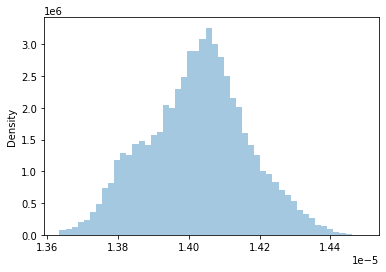

In [179]:
import seaborn as sns
sns.distplot(y_hats[-1].e.detach().cpu())

/home/justin/anaconda3/envs/caldera/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

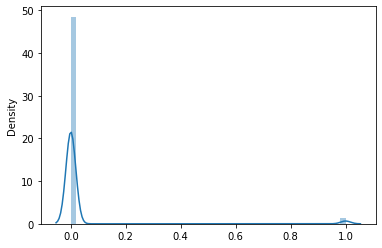

In [185]:
import seaborn as sns
sns.distplot(y.e.detach().cpu())